# Kaggle-Plant Seedlings Classification

## Description

This project aims to classify images of plant seedlings into 12 different species using deep learning. The dataset, provided by the Aarhus University Signal Processing group in collaboration with the University of Southern Denmark, contains approximately 960 unique plants at various growth stages.

We implement a Convolutional Neural Network (CNN) with transfer learning using MobileNetV2 to learn from the provided RGB images. The goal is to accurately identify the species of a seedling from its image, which has implications for improved crop yield and weed management.

Key components of this project include:
- Data preprocessing and augmentation
- CNN architecture and training
- Evaluation metrics (accuracy, confusion matrix)
- Visualization of prediction results

## Dataset Description

The dataset used in this project is from the Kaggle competition “Plant Seedlings Classification”. It contains images of plant seedlings taken at various stages of growth, captured under natural lighting conditions.

The training dataset includes 5,545 PNG images, distributed across 12 plant species. Each image is stored in a folder named after its plant species, making it suitable for image classification tasks using tools like `ImageFolder` (in PyTorch) or `flow_from_directory` (in Keras).

### Species classes:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherd’s Purse
- Small-flowered Cranesbill
- Sugar beet


In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.4 MB/s eta 0:00:0000:0100:01


In [42]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Image processing
from PIL import Image
import cv2

# Deep learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

# Visualization
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


## Data Visualization & EDA

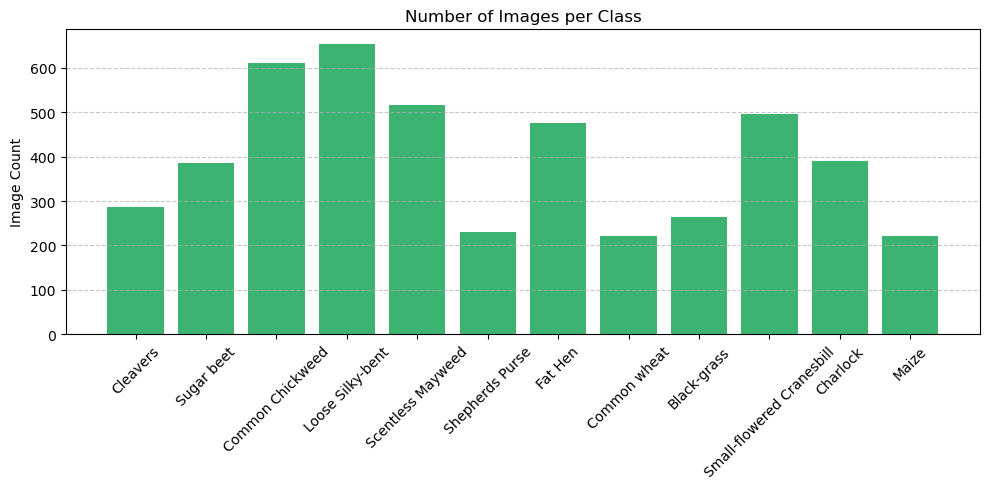

In [7]:
# Class Distribution Visualization (Bar Chart)
# Set training data path
train_dir = 'train/'

# Count the number of images in each class subfolder
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
}

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='mediumseagreen')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

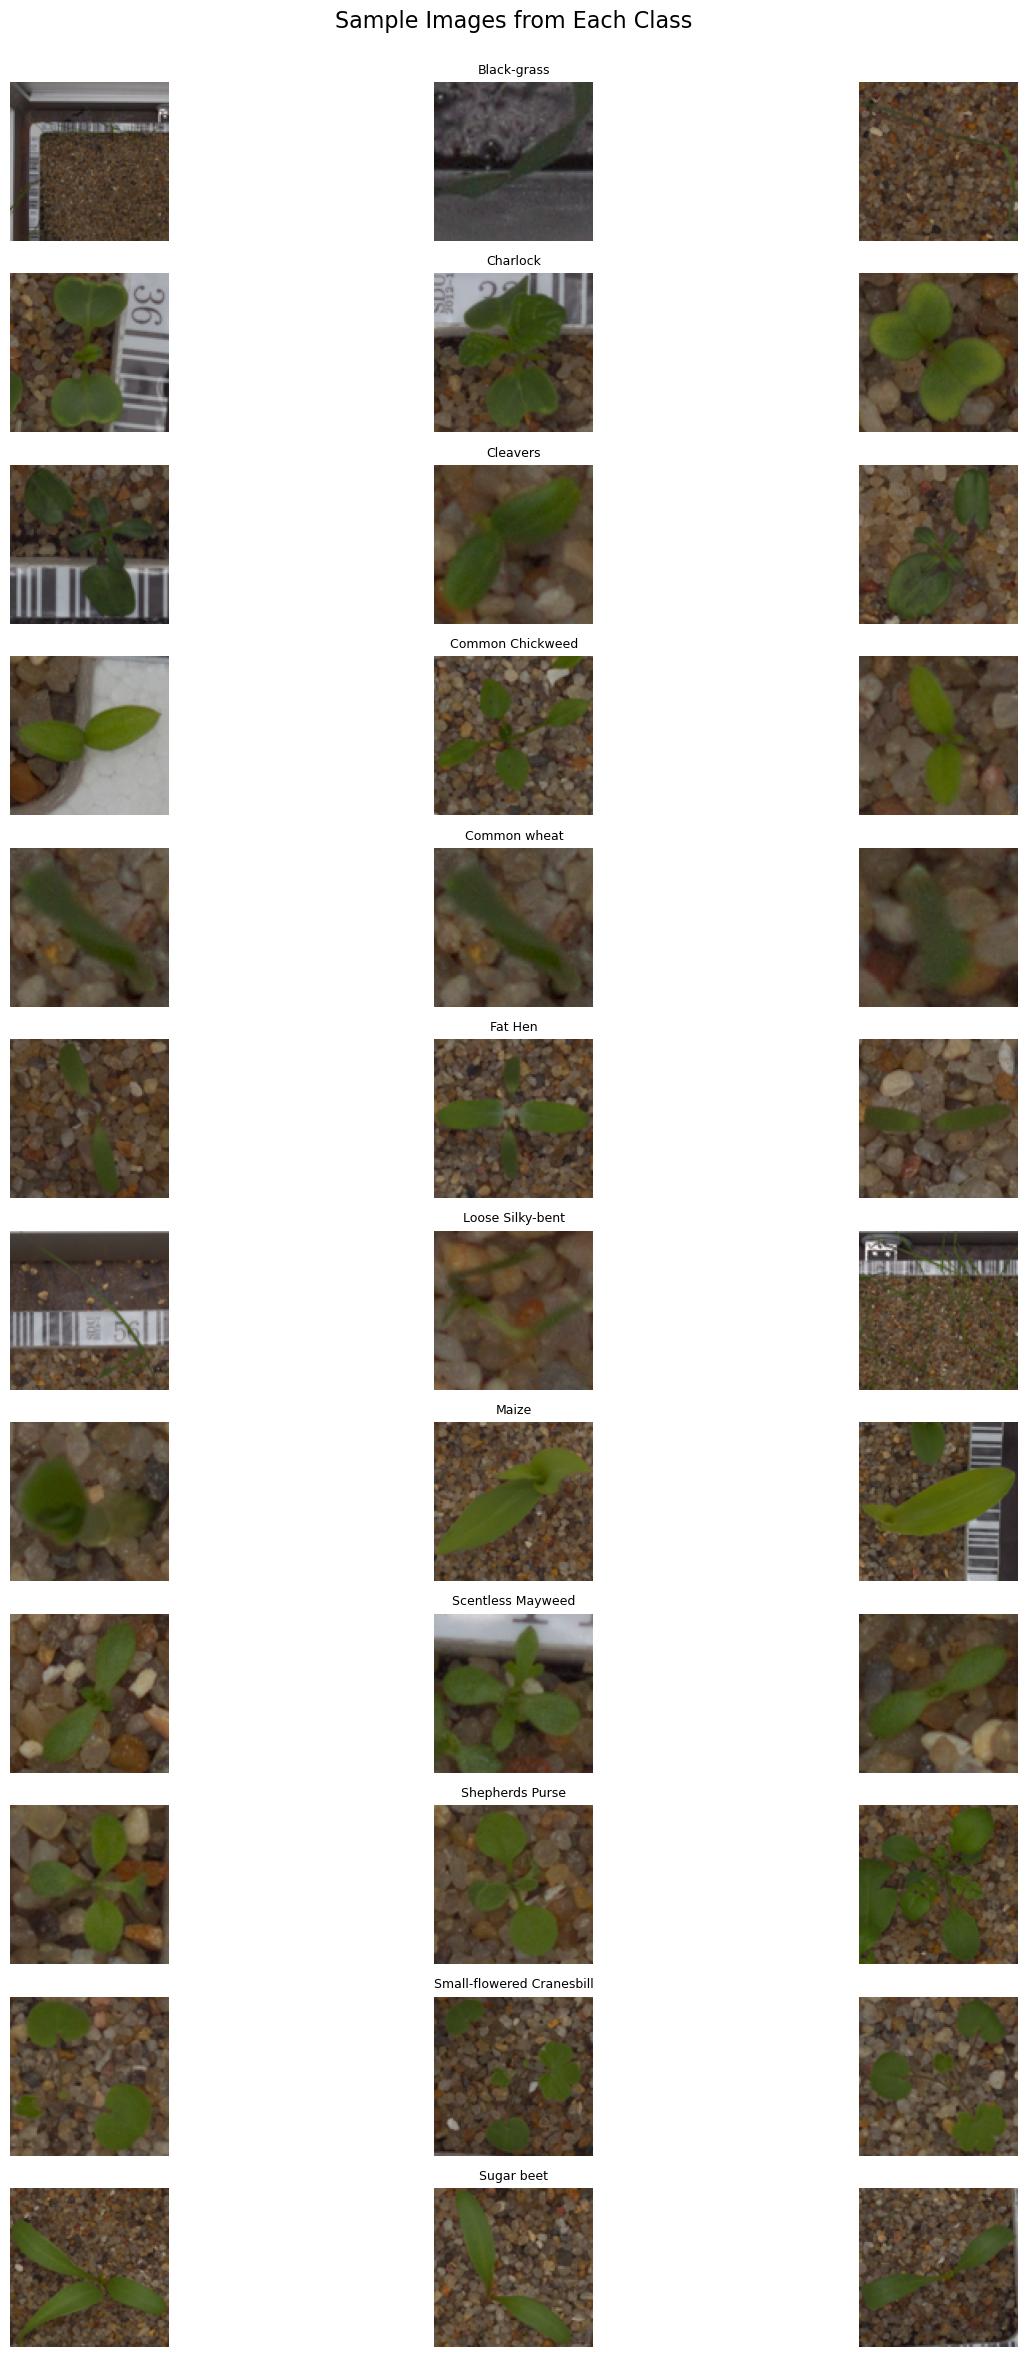

In [9]:
# Display Sample Images from Each Class
n_per_class = 3
img_size = (100,100)

# Sort class names for consistent display
class_list = sorted(os.listdir(train_dir))

plt.figure(figsize=(15,len(class_list) *2))

for i,cls in enumerate(class_list):
    img_names = os.listdir(os.path.join(train_dir,cls))
    for j in range(n_per_class):
        img_path=os.path.join(train_dir, cls, random.choice(img_names))
        img = Image.open(img_path).resize(img_size)

        plt.subplot(len(class_list), n_per_class, i * n_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(cls, fontsize=9)

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## Image Data Generator & Preprocessing

In [11]:
# Prepare ImageDataGenerator (Train & Validation)

# Image size for MobileNetV2 input (224x224), adjust for using simple CNN
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Define training image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In this section, I use `ImageDataGenerator` from Keras to preprocess and augment the images from the training set.

Key steps:
- **Rescaling**: Normalize pixel values from [0, 255] to [0, 1].
- **Data augmentation**: Apply random transformations (rotation, zoom, shift, flip) to improve generalization and prevent overfitting.
- **Train-validation split**: 80% of the training images are used for training, and 20% are used for validation. This is done automatically using `validation_split`.

And then use `flow_from_directory()` to load images directly from the `train/` folder, where images are organized in subfolders by class.

The output below confirms that:
- 3803 images are used for training
- 947 images are used for validation
- All 12 classes are correctly detected

## Model: Build a Simple CNN (from scratch)

In [15]:
# Build Model Architecture (Keras)
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # 12 classes
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In this section, I build a custom Convolutional Neural Network (CNN) using Keras `Sequential` API.

The model architecture includes:
- Three convolutional blocks with increasing filter sizes (32 → 64 → 128)
- Batch normalization after each convolution layer to stabilize learning
- Max pooling to reduce spatial dimensions
- A fully connected (Dense) layer with dropout to prevent overfitting
- A final Dense layer with softmax activation to output class probabilities for 12 plant species

This model is simpler than pre-trained networks like MobileNetV2, but suitable for learning and baseline performance.

In [17]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

The model is compiled with:
- Adam optimizer: efficient and widely used for deep learning
- Categorical crossentropy: suitable for one-hot encoded multi-class classification
- Accuracy: used to monitor the classification performance during training

## Model Training：Train the CNN 

In [21]:
# Stop training early if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Save the best model (based on validation accuracy)
model_ckpt = ModelCheckpoint(
    filepath='best_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

Two callbacks are added to improve training efficiency and avoid overfitting:

1. EarlyStopping:
    - Monitors the validation loss during training.
    - If the validation loss does not improve for 3 consecutive epochs (patience=5),
      training will stop early.
    - The model will restore the best weights observed during training.

2. ModelCheckpoint:
    - Saves the model weights to a file ('best_cnn_model.h5') whenever the validation accuracy improves.
    - Ensures that we always retain the best-performing version of the model.

In [24]:
# Model training
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2036 - loss: 16.8328 - val_accuracy: 0.0845 - val_loss: 52.4020
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.1791 - loss: 2.4828 - val_accuracy: 0.1626 - val_loss: 4.0352
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.2306 - loss: 2.3360 - val_accuracy: 0.1911 - val_loss: 3.3191
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.2899 - loss: 2.1919 - val_accuracy: 0.1341 - val_loss: 2.4326
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3285 - loss: 2.1660 - val_accuracy: 0.3326 - val_loss: 1.9780
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3313 - loss: 2.0470 - val_accuracy: 0.2386 - val_loss: 2.2777
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3421 - loss: 2.1206 - val_accuracy: 0.3907 - val_loss: 1.9031
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3321 - loss: 2.0713 - val_ac

The model is trained using model.fit() for up to 10 epochs.
- EarlyStopping will halt training if the model stops improving on validation loss for 5 consecutive epochs.
- ModelCheckpoint saves the best-performing model based on validation accuracy to 'best_cnn_model.h5'.

### Evaluation & Visualization – Plot Loss and Accuracy Curves

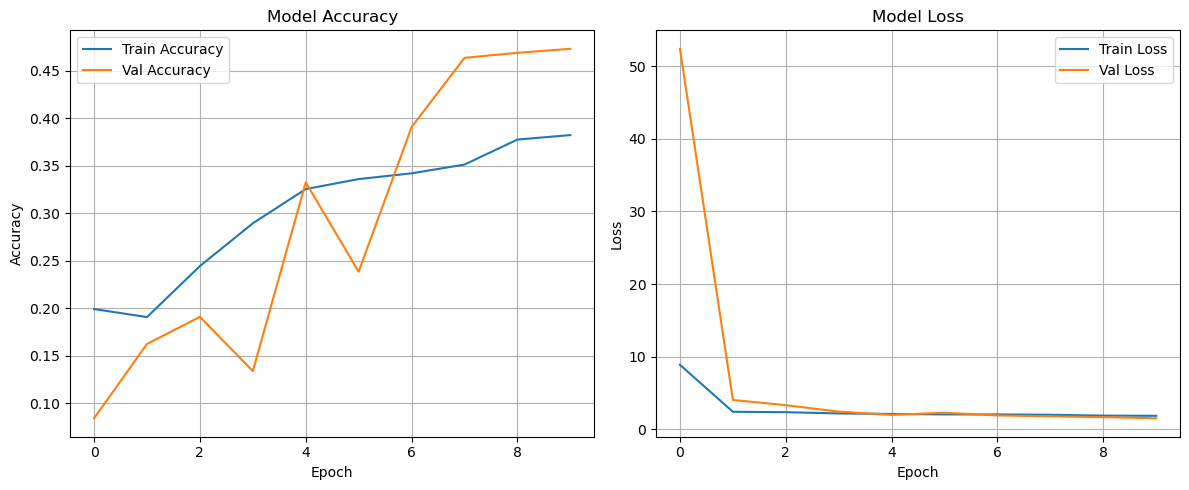

In [26]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- The left plot shows how training and validation accuracy changed over epochs.
- The right plot shows the corresponding training and validation loss.
- These curves help assess whether the model is overfitting or underfitting.
- In this case, I observe a steady improvement, indicating learning is progressing.
- The left plot shows that both training and validation accuracy steadily increase over epochs, indicating that the model is effectively learning.

- The right plot shows a significant drop in loss, especially a sharp decrease in validation loss after epoch 1, suggesting rapid improvement in model performance.


## 🔧Hyperparameter Tuning 

To improve model performance and training stability, several key hyperparameters were modified:

1. **Learning Rate**  
   - Changed from the default (`1e-3`) to a smaller value of `1e-4`.  
   - This helps achieve more stable and gradual convergence during training.

2. **Epochs**  
   - Increased from 10 to 20.  
   - Combined with EarlyStopping to allow the model enough time to learn, but stop if it starts overfitting.

3. **Data Augmentation (Stronger)**  
   - Increased `rotation_range` from 20 → 30  
   - Increased `zoom_range` from 0.15 → 0.2  
   - Increased `width_shift_range` and `height_shift_range` to 0.2  
   - Added `brightness_range=[0.8, 1.2]`  
   - These enhancements help the model generalize better to various lighting and positioning conditions.

4. **ModelCheckpoint Format Update**  
   - Changed model file extension from `.h5` to `.keras` as required by Keras 3.x.

These changes were made to reduce overfitting, enhance generalization, and improve validation accuracy.


In [32]:
# ==== 1. Define Constants ====
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20

# ==== 2. Enhanced Data Augmentation ====
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

# ==== 3. Build CNN Model ====

model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE + (3,)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # 12 plant species
])

# ==== 4. Compile the Model ====
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller LR = more stable training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==== 5. Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_ckpt = ModelCheckpoint(
    filepath='best_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# ==== 6. Train the Model ====
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.2016 - loss: 3.6183 - val_accuracy: 0.0676 - val_loss: 10.7812
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3091 - loss: 2.0773 - val_accuracy: 0.0739 - val_loss: 9.8357
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3462 - loss: 1.9671 - val_accuracy: 0.1447 - val_loss: 7.4842
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.3557 - loss: 1.8637 - val_accuracy: 0.2281 - val_loss: 2.5279
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3880 - loss: 1.7978 - val_accuracy: 0.4234 - val_loss: 1.7063
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3948 - loss: 1.7654 - val_accuracy: 0.4784 - val_loss: 1.5942
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4395 - loss: 1.6964 - val_accuracy: 0.5206 - val_loss: 1.5907
Epoch 8/20


After applying several key hyperparameter adjustments—including enhanced data augmentation, a smaller learning rate (1e-4), and extended training epochs (from 10 to 20)—the model achieved a significant improvement:

- Validation accuracy increased from **0.07 → 0.74**
- Validation loss decreased from **10.78 → 0.86**
- The training remained stable without severe overfitting

These results indicate that the model is now learning meaningful patterns and generalizing well to unseen data.

### Plot Loss & Accuracy Curves

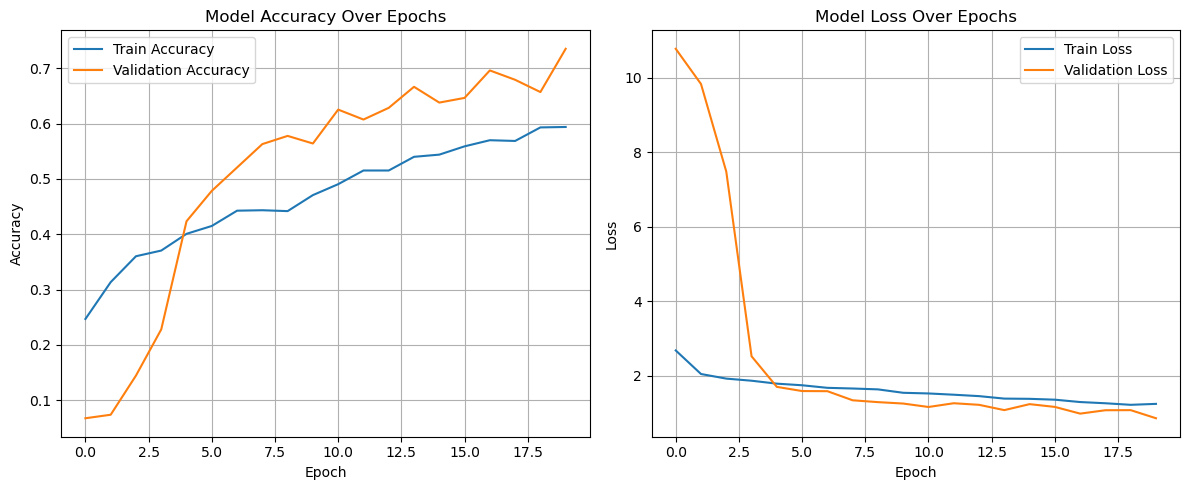

In [34]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- The accuracy plot shows steady improvement on both training and validation sets,reaching ~73% validation accuracy after tuning.
- The loss plot indicates that both training and validation loss decrease consistently,showing no major signs of overfitting.
- These curves confirm that the model is learning effectively with the new hyperparameters.

## 📊 Summary Before vs After Hyperparameter Tuning

The effect of tuning key hyperparameters—such as learning rate, data augmentation, and training duration—was significant.

- Validation accuracy improved from **47.3% → 73.5%**
- Validation loss reduced from **1.52 → 0.86**
- Training accuracy also increased from **39.9% → 58.3%**

This confirms that the adjusted training settings allowed the model to learn more effectively and generalize better to unseen validation data. The enhanced data augmentation and lower learning rate played a key role in stabilizing training and preventing overfitting.


## Prediction on Test Set & Export Submission

Below script loads the final tuned model, applies it to all test set images, and exports a prediction CSV file named `submission.csv`.

- The output format matches `sample_submission.csv`.
- Each row contains the image filename and the predicted plant species.
- The prediction uses softmax class probabilities and picks the most likely class.

In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ==== 1. Load the best model ====
model = load_model('best_cnn_model.keras')  # Already confirmed tuned ✅

# ==== 2. Get class index mapping from train_generator ====
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # idx → class name

# ==== 3. Predict test images ====
test_dir = 'test/'
image_files = sorted(os.listdir(test_dir))
results = []

for fname in image_files:
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # basic check
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        pred_label = class_names[np.argmax(pred)]
        results.append([fname, pred_label])

# ==== 4. Save to submission.csv ====
submission_df = pd.DataFrame(results, columns=['file', 'species'])
submission_df.to_csv('submission.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

## 🏁 Final Result

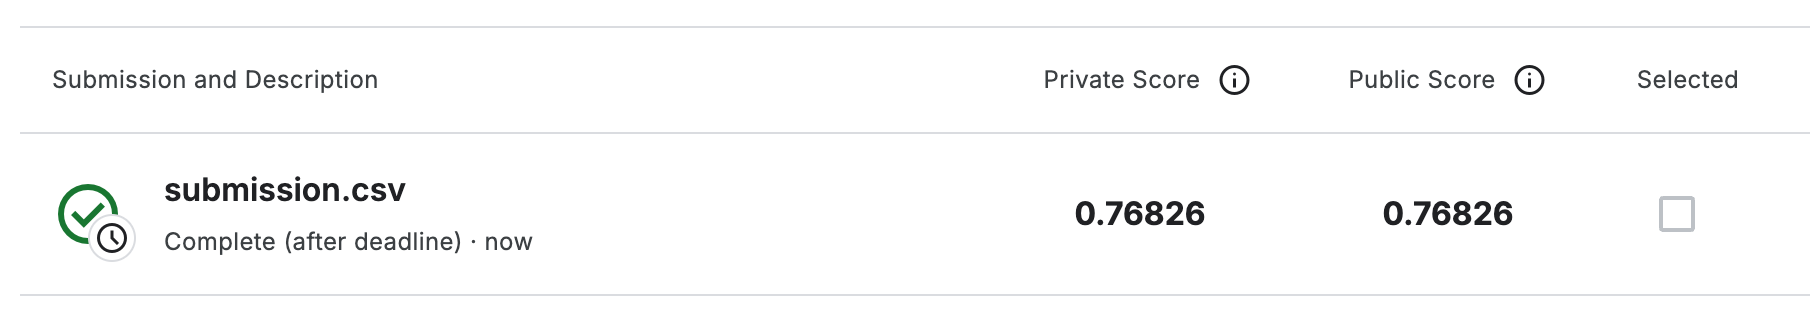

The final model achieved a Kaggle score of 0.76826 on both the public and private test sets, indicating strong generalization performance. This confirms the effectiveness of the tuned CNN model for plant seedling classification and marks the successful completion of the project.

## 📌 Future Improvements

- Try pretrained models (e.g. MobileNetV2, EfficientNet)
- Use Grad-CAM to visualize model decisions
- Deploy as web app with Flask or Streamlit